## TALLER 3:
1.    Utilizando librerías solo de Numpy (sin usar scikit-learn) realizar un programa para aplicar **PCA**. Pruebe su algoritmo con la base de datos del taller 1 tomando solo los individuos con patologías: Left bundle Branch block beat y Right bundle Branch block beat. ¿Cuántas componentes fueron necesarias para representar el 95% de la varianza explicada?
2.    Utilizando librerías solo de Numpy (sin usar scikit-learn) realizar un programa para aplicar **K-means**. Pruebe el resultado y grafique en dos dimensiones a partir de los datos obtenidos del taller 1. Agrupe en 4 clúster. ¿Hay relación entre los datos agrupados por clústers y el tipo de patología del paciente?
3.    Utilizando librerías solo de Numpy (sin usar scikit-learn) realizar un programa para aplicar **KNN**. Pruebe el resultado obtenido a partir de los datos derivados del punto 1. Utilice 30% de los datos para pruebas y reporte: Exactitud (accuracy), sensibilidad (recall), precisión, especificidad y F1-score, y dibuje la matriz de confusión.
4.    Utilizando scikit-learn implementar **regresión logística** sobre los datos del taller 1. Aplique OVR para la realizar la clasificación multiclase. Reporte exactitud, sensibilidad, especificidad y precisión, y dibuje la matriz de confusión ¿Cómo deben realizarse las métricas de desempeño cuando la clasificación es multiclase?
5.    Suponga que el siguiente conjunto de scores corresponde a los resultados de un clasificador. Dibuje manualmente la curva ROC, construya la matriz de confusión, y calcule exactitud, precisión, sensibilidad, especificidad y F1-score (son en total 40 datos).

The purpose of this paper is to develop an algorithm for recognizing and classifying 
- **N:** normal beat
- **L:** left bundle branch block beat
- **R:** right bundle branch block beat 
- **V:** premature ventricular contraction (PVC).

In [280]:
# Librerías comunes
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import joblib # Save weight models
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels

# Para crear un modelo scikit-learn 
from sklearn.base import BaseEstimator, MultiOutputMixin

# Modelos
from sklearn.linear_model import LogisticRegression

# Métricas, división de datos y entrenamiento de hipeparametros respectivamente
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, make_scorer, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [124]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(y_true))
    
    y_true = le.transform(y_true)
    y_pred = le.transform(y_pred)
    
    classes = le.classes_
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [44]:
df_electCard = pd.read_csv('cleaned_electrocardiograma_dataset.csv')
df_electCard.drop("Sample", axis=1, inplace=True)
df_electCard.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c241,c242,c243,c244,c245,c246,c247,c248,c249,Type
0,964,963,962,960,958,959,961,962,963,963,...,961.0,963,961.0,961.0,962.0,965.0,966.0,963.0,962.0,N
1,955,955,958,958,957,955,954,954,956,958,...,960.0,960,960.0,959.0,954.0,954.0,956.0,957.0,958.0,N
2,955,955,956,953,951,952,953,953,953,949,...,963.0,961,962.0,961.0,965.0,964.0,962.0,958.0,956.0,N
3,954,954,956,956,955,955,948,952,952,955,...,963.0,964,964.0,961.0,959.0,957.0,959.0,961.0,960.0,N
4,961,961,958,958,957,957,958,958,958,956,...,969.0,966,965.0,963.0,965.0,965.0,967.0,966.0,964.0,N


# 1. PCA from scratch

In [45]:
class PCAjj:
    
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit_transform(self, X):
        
        self.X = X
        self.covariance = np.cov(self.X.T)
        self.eig_values, self.eig_vectors = np.linalg.eig(self.covariance)
        
        self.explained_variance_ = self.eig_values[:self.n_components]
        self.explained_variance_ratio_ = self.eig_values[:self.n_components] / self.eig_values.sum()
        
        self._W = self.eig_vectors[:,:self.n_components] # Selecciono el número de eigen vectors que quiero
        self.new_X = np.negative(np.dot(X, self._W)) # Matriz X reducida
        
        return self.new_X

In [46]:
df_electCard_2_labels = df_electCard[df_electCard.Type.isin(['R', 'L'])]
df_electCard_2_labels.Type.value_counts()

L    8072
R    6417
Name: Type, dtype: int64

In [47]:
X = df_electCard_2_labels.iloc[:, :250]
X = (X - X.mean(axis = 0)) / X.std(axis = 0)

In [48]:
pcajj = PCAjj(n_components = 5)
X_pca = pcajj.fit_transform(X)
y_pca = df_electCard[df_electCard.Type.isin(['R', 'L'])].Type
pcajj.explained_variance_ratio_.sum()

0.9629118228936789

Filtrando mi dataset con los tipos left bundle branch block beat (**L**) y right bundle branch block beat (**R**), se aplicó PCA en busca del 95% de varianza explicada, la cual se consiguió con 5 componentes.

# 2. K-means from scratch

In [49]:
class KMeansJJ:

    def __init__(self, n_clusters=2, random_state=0, iterations = 50):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.iterations = iterations
    
    def fit(self, X):
        self.cluster_centers_ = X[np.random.randint(X.shape[0], size=self.n_clusters)]
        self.targets = np.arange(self.n_clusters)
        self.labels_ = self.predict(X)
        self.X = X
        
        for i in range(self.iterations):
            self.__ajustarCentroides()
            self.labels_ = self.predict(X)
        
    def predict(self, X_test):
        lista = []
        
        for regis in range(X_test.shape[0]):
            temp = np.sqrt(np.sum(np.power(self.cluster_centers_ - X_test[regis], 2), axis = 1))
            lista.append(np.argmin(temp))
            
        lista = np.array(lista)
        return lista      
    
    def __ajustarCentroides(self):
        
        for target in self.targets:
            indices = np.where(self.labels_ == target)
            self.cluster_centers_[target] = self.X[indices].mean(axis = 0)
            

In [50]:
df_electCard.Type.value_counts()

N    73537
L     8072
V     7072
R     6417
Name: Type, dtype: int64

In [51]:
X_comp = df_electCard.iloc[:, :250]
X_comp = (X_comp - X_comp.mean(axis = 0)) / X_comp.std(axis = 0)
X_comp.shape

(95098, 250)

In [52]:
pcajj_comp = PCAjj(n_components = 2)
X_comp = pcajj_comp.fit_transform(X_comp)
print(pcajj_comp.explained_variance_ratio_.sum())

0.8137214114549118


In [53]:
kmeansJJ = KMeansJJ(n_clusters = 4, iterations=50)
kmeansJJ.fit(X_comp)
predictions = kmeansJJ.predict(X_comp)

In [54]:
centroides = kmeansJJ.cluster_centers_
centroides

array([[ -9.33298741,   0.45228946],
       [ 12.38396453,   2.64407082],
       [  4.02129102,  -2.00279868],
       [-23.12527186,   0.6848043 ]])

In [55]:
puntosN = X_comp[df_electCard.Type == 'N']
puntosL = X_comp[df_electCard.Type == 'L']
puntosR = X_comp[df_electCard.Type == 'R']
puntosV = X_comp[df_electCard.Type == 'V']

puntos0 = X_comp[predictions == 0]
puntos1 = X_comp[predictions == 1]
puntos2 = X_comp[predictions == 2]
puntos3 = X_comp[predictions == 3]

Text(0.5, 0.98, 'PCA y después cluster')

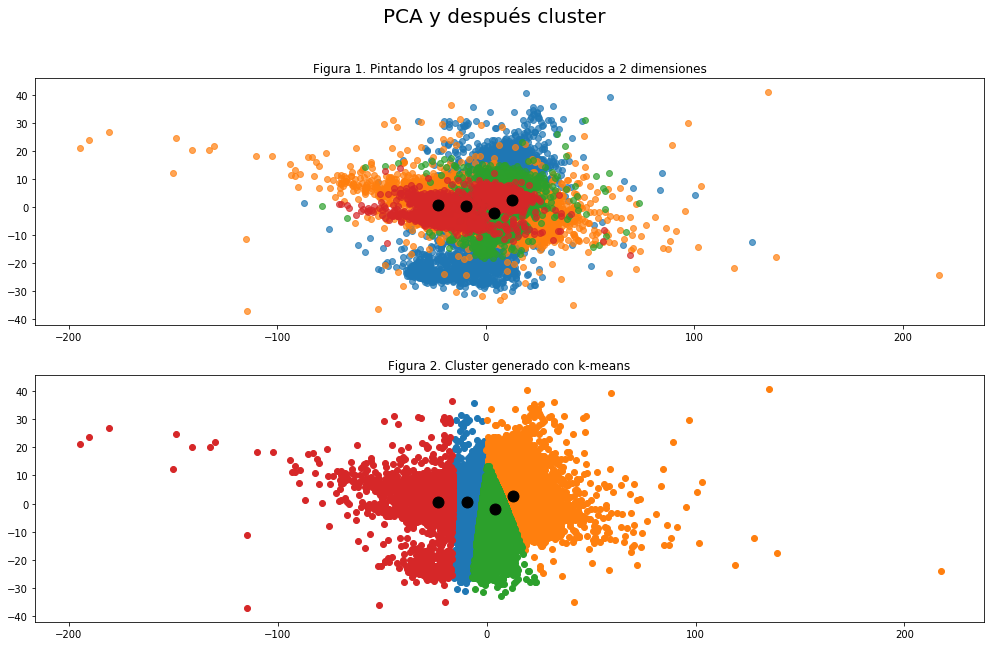

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(17, 10), sharey=True)

axs[0].scatter(puntosV[:, 0], puntosV[:, 1], alpha=0.7)
axs[0].scatter(puntosN[:, 0], puntosN[:, 1], alpha=0.7)
axs[0].scatter(puntosL[:, 0], puntosL[:, 1], alpha=0.7)
axs[0].scatter(puntosR[:, 0], puntosR[:, 1], alpha=0.7)
axs[0].scatter(centroides[:, 0], centroides[:, 1],  s=120, color = 'black')
axs[0].set_title("Figura 1. Pintando los 4 grupos reales reducidos a 2 dimensiones")


axs[1].scatter(puntos0[:, 0], puntos0[:, 1])
axs[1].scatter(puntos1[:, 0], puntos1[:, 1])
axs[1].scatter(puntos2[:, 0], puntos2[:, 1])
axs[1].scatter(puntos3[:, 0], puntos3[:, 1])
axs[1].scatter(centroides[:, 0], centroides[:, 1],  s=120, color = 'black')
axs[1].set_title("Figura 2. Cluster generado con k-means")

fig.suptitle('PCA y después cluster',  fontsize=20)

Como se observa en los gráficos anteriores, PCA reducido a 2 dimensiones en este dataset no me permite tener los datos lo suficiente separados; de manera que k-means tampoco tenía posibilidad de trabajar correctamente ya que los 4 grupos se intersectaban entre si (Figura 1). Es por este mismo motivo que tampoco se puede sacar conlusiones de los anteriores clusters generados, ni de la patología de los pacientes.

# 3. KNN from scratch

In [57]:
class KNN(BaseEstimator, MultiOutputMixin):
    
    def __init__(self, K = 2):
        
        self.K = K
  
    def fit(self, X, y):
        
        self.X = X
        self.y = y
        
        return self
    
    def predict(self, X_new):
        
        predictions = [self.predict_one_value(X_new.iloc[i].values) for i in range(len(X_new))]
        
        return np.array(predictions)
        
    def predict_one_value(self, x_new):
        
        dists = np.sum(np.abs(self.X - x_new), axis=1)  # Aplicando la formula manhatan
        dists = sorted(enumerate(dists), key=lambda dis:dis[1])  # Ordeno manteniendo guardadas las posiciones antes originales
        
        y_hat = stats.mode([self.y.iloc[elm_d[0]] for elm_d in dists[:self.K]])[0][0]

        return y_hat

In [58]:
X_pca = pd.DataFrame(X_pca)
y_pca = pd.DataFrame(y_pca).Type

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.30, random_state=42)

In [60]:
y_test.value_counts()

L    2426
R    1921
Name: Type, dtype: int64

In [61]:
%%time
parameters = {    
  'K':[5, 7, 11, 17],
}

scorer = make_scorer(accuracy_score)
knn = KNN()
grid_obj = GridSearchCV(knn, param_grid=parameters, scoring=scorer, cv=5)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_

CPU times: user 3min 41s, sys: 13.5 ms, total: 3min 41s
Wall time: 3min 41s


In [62]:
predictions = best_clf.predict(X_test)

Source: https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/

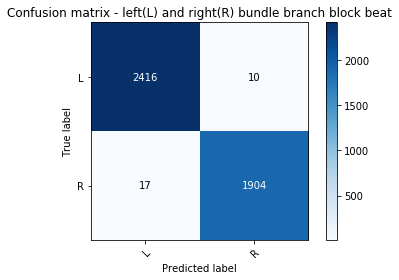

In [125]:
plot_confusion_matrix(y_test, predictions, title = "Confusion matrix - left(L) and right(R) bundle branch block beat");

In [126]:
tn, fp, fn, tp = confusion_matrix(predictions, y_test).ravel()

In [128]:
accuracy_ = accuracy_score(predictions, y_test)
recall_ = recall_score(predictions, y_test, pos_label="R")
f1_ = f1_score(predictions, y_test, pos_label="R")
precision_ = precision_score(predictions, y_test, pos_label="R")

print(f"(Exactitud) Accuracy: {accuracy_}")         # (2416 + 1904) / (2416 + 1904 + 10 + 17)
print(f"(Sensibilidad) Recall: {recall_}")          # 2416 / (2416 + 17)
print(f"(Especificidad) Specificity {tn / (tn + fp)}")
print(f" Precision: {precision_}")                  # (2416) / (2416 + 10)
print(f" F1_score: {f1_}")                          # 2 * (precision * recall) / (precision + recall)

(Exactitud) Accuracy: 0.9937888198757764
(Sensibilidad) Recall: 0.9947753396029259
(Especificidad) Specificity 0.9930127414714345
 Precision: 0.9911504424778761
 F1_score: 0.9929595827900913


- La exactitud (accuracy) permite determinar de todos las predicciones, qué proporción fue clasificado correctamente sin importar si es 'L' o 'R'.
- La sensibilidad (recall), indica la proporción de todos los clasificados como postivos (L) cuáles fueron clasificados correctamente.
- La especificidad, indica la proporción de todos los clasificados como negativos (R) cuáles fueron clasificados correctamente.
- La precisión: de los datos clasificados correctamente qué proporción son positivos.
- Usando la puntuación F1 como métrica, estamos seguros de que si la puntuación F1 es alta, tanto la precisión como el recall del clasificador indican buenos resultados. Esa característica de la métrica nos permite comparar el rendimiento de dos clasificadores usando solo una métrica y aún así estar seguros de que los clasificadores no están cometiendo algunos errores horribles que pasan desapercibidos para el código que califica su salida.

Finalmente la matrix de confusión me permite determinar con más detalle las predicciones entendiendo cuales fueron clasificadas correctamente como 'L' cuáles como 'R' y con cuántas predicciones se confundió el modelo diciendo que era 'R' cuando en realidad era 'L' y viceversa.

# 4. Logistic Regression with One vs Rest (OVR)

Utilizando scikit-learn implementar regresión logística sobre los datos del taller 1. Aplique OVR para la realizar la clasificación multiclase. Reporte exactitud, sensibilidad, especificidad y precisión, y dibuje la matriz de confusión ¿Cómo deben realizarse las métricas de desempeño cuando la clasificación es multiclase?

In [11]:
X_ovr = df_electCard.drop("Type", axis=1)
y_ovr = df_electCard.Type
X_ovr.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c240,c241,c242,c243,c244,c245,c246,c247,c248,c249
0,964,963,962,960,958,959,961,962,963,963,...,963,961.0,963,961.0,961.0,962.0,965.0,966.0,963.0,962.0
1,955,955,958,958,957,955,954,954,956,958,...,958,960.0,960,960.0,959.0,954.0,954.0,956.0,957.0,958.0
2,955,955,956,953,951,952,953,953,953,949,...,964,963.0,961,962.0,961.0,965.0,964.0,962.0,958.0,956.0
3,954,954,956,956,955,955,948,952,952,955,...,959,963.0,964,964.0,961.0,959.0,957.0,959.0,961.0,960.0
4,961,961,958,958,957,957,958,958,958,956,...,969,969.0,966,965.0,963.0,965.0,965.0,967.0,966.0,964.0


In [14]:
X_train_ovr, X_test_ovr, y_train_ovr, y_test_ovr = train_test_split(X_ovr, y_ovr, test_size=0.30, random_state=42)
filename = 'logRegPoint4.sav'

In [31]:
%%time
lgr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=20000).fit(X_train_ovr, y_train_ovr)

CPU times: user 38min 3s, sys: 12.1 s, total: 38min 15s
Wall time: 9min 33s


In [9]:
# Saving my model's weitghs, because take a lot of time train the model
joblib.dump(lgr, filename);

In [15]:
# load the model from disk
lgr = joblib.load(filename)

In [16]:
predictions_lgr = lgr.predict(X_test_ovr)

In [129]:
accuracy_ovr = accuracy_score(y_test_ovr, predictions_lgr)
recall_ovr = recall_score(y_test_ovr, predictions_lgr, average=None)
f1_ovr = f1_score(y_test_ovr, predictions_lgr, average=None)
precision_ovr = precision_score(y_test_ovr, predictions_lgr, average=None)

print(f"(Exactitud) Accuracy: {accuracy_ovr}") # (1517 + 21516 + 1685 + 1346) / total de datos
print(f"(Sensibilidad) Recall: {recall_ovr}")
print(f" Precision: {precision_ovr}")
print(f" F1_score: {f1_ovr}")   

(Exactitud) Accuracy: 0.9135646687697161
(Sensibilidad) Recall: [0.63552576 0.97379498 0.87851929 0.63192488]
 Precision: [0.81253348 0.92781371 0.95036661 0.79176471]
 F1_score: [0.7132111  0.95024843 0.9130317  0.70287206]


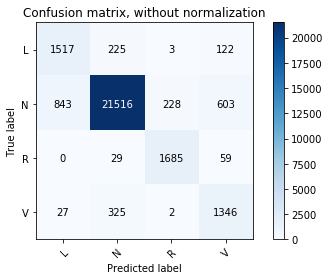

In [118]:
plot_confusion_matrix(y_test_ovr, predictions_lgr, normalize=False);

Para realizar la matriz de confusión multiclase, se sigue el mismo principio que de forma binaria. Sin embargo. En el caso de sensibilidad, especificada y precisión ya no sólo se obtiene un único resultado, sino que se calcula clase por clase.

- https://stackoverflow.com/questions/45890328/sklearn-metrics-for-multiclass-classification
- https://www.youtube.com/watch?v=HBi-P5j0Kec

Tenga en cuenta que la matriz de confusión sklearn trabaja un poco diferente a como encontramos los ejemplos en internet. Esto se debe a que normalmente si inverten los falsos positivos y falsos negativos. Para mayor información:
- https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019.

# 5. Curva ROC from scratch

In [274]:
y_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
prediccion =  np.array([0.97, 0.71, 0.16, 0.54, 0.67, 0.73, 0.56, 0.24, 0.98, 0.09, 0.89, 0.84, 0.74, 0.43, 0.78, 0.99, 0.65, 0.64, 0.50,
                   0.33, 0.23, 0.45, 0.54, 0.78, 0.04, 0.01, 0.65, 0.23, 0.41, 0.32, 0.67, 0.32, 0.76, 0.23, 0.32, 0.49, 0.15, 0.19])

# ordenamos
ind_sort = prediccion.argsort()
prediccion.sort()
y_true_copia  = []
for i in ind_sort:
    y_true_copia.append(y_true[i])
y_true = y_true_copia

print(prediccion)
print(y_true)

[0.01 0.04 0.09 0.15 0.16 0.19 0.23 0.23 0.23 0.24 0.32 0.32 0.32 0.33
 0.41 0.43 0.45 0.49 0.5  0.54 0.54 0.56 0.64 0.65 0.65 0.67 0.67 0.71
 0.73 0.74 0.76 0.78 0.78 0.84 0.89 0.97 0.98 0.99]
[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


In [297]:
recall_s = []
precision_s = []

for limite in np.arange(0.01, 1+0.01, 0.01):
    
    y_pred = []
    
    for pr_i in prediccion.argsort():
        if prediccion[pr_i] < limite:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    print(f1_score(y_true, y_pred), limite)
    recall_s.append(recall_score(y_true, y_pred))
    precision_s.append(precision_score(y_true, y_pred))

0.0 0.01
0.0 0.02
0.0 0.03
0.0 0.04
0.0 0.05
0.0 0.060000000000000005
0.0 0.06999999999999999
0.0 0.08
0.0 0.09
0.09090909090909091 0.09999999999999999
0.09090909090909091 0.11
0.09090909090909091 0.12
0.09090909090909091 0.13
0.09090909090909091 0.14
0.08695652173913043 0.15000000000000002
0.08695652173913043 0.16
0.16666666666666666 0.17
0.16666666666666666 0.18000000000000002
0.16666666666666666 0.19
0.16 0.2
0.16 0.21000000000000002
0.16 0.22
0.16 0.23
0.20689655172413793 0.24000000000000002
0.20689655172413793 0.25
0.20689655172413793 0.26
0.20689655172413793 0.27
0.20689655172413793 0.28
0.20689655172413793 0.29000000000000004
0.20689655172413793 0.3
0.20689655172413793 0.31
0.20689655172413793 0.32
0.18749999999999997 0.33
0.18181818181818182 0.34
0.18181818181818182 0.35000000000000003
0.18181818181818182 0.36000000000000004
0.18181818181818182 0.37
0.18181818181818182 0.38
0.18181818181818182 0.39
0.18181818181818182 0.4
0.17647058823529413 0.41000000000000003
0.17647058823529

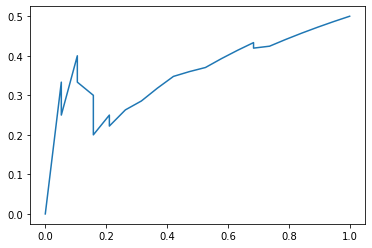

In [281]:
plt.plot(recall_s, precision_s)

In [277]:
roc_auc_score(y_true, prediccion)

0.7728531855955678

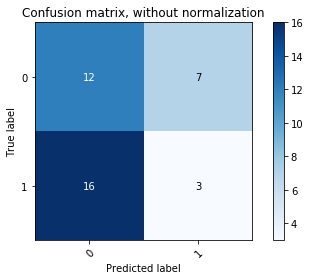

In [301]:
y_pred = []
    
for pr_i in prediccion.argsort():
    if prediccion[pr_i] < 0.32:
        y_pred.append(1)
    else:
        y_pred.append(0)

recall_s.append(recall_score(y_true, y_pred))
precision_s.append(precision_score(y_true, y_pred))
    
plot_confusion_matrix(y_true, y_pred, normalize=False);

In [292]:
tn, fp, fn, tp = confusion_matrix(predictions, y_test).ravel()

accuracy_ = accuracy_score(y_true, y_pred)
recall_ = recall_score(y_true, y_pred)
f1_ = f1_score(y_true, y_pred)
precision_ = precision_score(y_true, y_pred)

print(f"(Exactitud) Accuracy: {accuracy_}")
print(f"(Sensibilidad) Recall: {recall_}")
print(f"(Especificidad) Specificity {tn / (tn + fp)}")
print(f" Precision: {precision_}")
print(f" F1_score: {f1_}")

(Exactitud) Accuracy: 0.4473684210526316
(Sensibilidad) Recall: 0.10526315789473684
(Especificidad) Specificity 0.9930127414714345
 Precision: 0.3333333333333333
 F1_score: 0.16
